In [2]:
# Import libraries
%load_ext autoreload
%autoreload 2

from pulse_lib.pickle_parse import *
from pulse_lib.phase_calibration import *

from qick import *
import Pyro4
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ


In [456]:
seq = {}
seq["i"] = [(100000, 1.0, 3, 0)]
seq["q"] = [(100000, 1.0, 3, 90)]
seq["dig"] = [(40000, 0), (10000, 1), (50000, 1)]

# Gain and delay defaults are specified - not necessary to assign individually
# Multiplicative gain for DAC amplitudes
gains = {"DAC_A": 32767,
         "DAC_B": 32767
         }

# Channel trigger delays for synchronisation
delays = {"DAC_A": 0,
          "DAC_B": 0,
          }

# Method 1: use if keys don't match channel names
ch_map={"DAC_A": "i",
        "DAC_B": "q",
        "DIG_0": "dig"
        }

pulse_sequences = PickleParse(seq,
                              ch_map=ch_map,
                              gains=gains,
                              delays=delays
                              )

----- DAC A -----
ch_type: DAC
ch_index: 1
delay: 0
gain: 32767
lengths: [100.0]
times: [0.0]
amps: [1.0]
freqs: [3000.0]
phases: [0]
num_pulses: 1
duration: 100.0
----- DAC B -----
ch_type: DAC
ch_index: 0
delay: 0
gain: 32767
lengths: [100.0]
times: [0.0]
amps: [1.0]
freqs: [3000.0]
phases: [90]
num_pulses: 1
duration: 100.0
----- DIG 0 ------
ch_type: DIG
ch_index: 0
delay: 0
lengths: [10.0, 50.0]
times: [40.0, 50.0]
num_pulses: 2
duration: 100.0
----- End time: 100.0 -----


In [457]:
res = []
config = {"reps": 1}
dac_freqs = sorted(list(set(pulse_sequences.ch_cfg["DAC_A"]["freqs"] + pulse_sequences.ch_cfg["DAC_B"]["freqs"])))

for freq in dac_freqs:
    config['pulse_freq'] = freq
    prog = CalibratePhase(soccfg, config)
    data = prog.acquire_decimated(soc, progress=False)
    res.append([prog.calculate_phase(d) for d in data])
    soc.reset_gens()

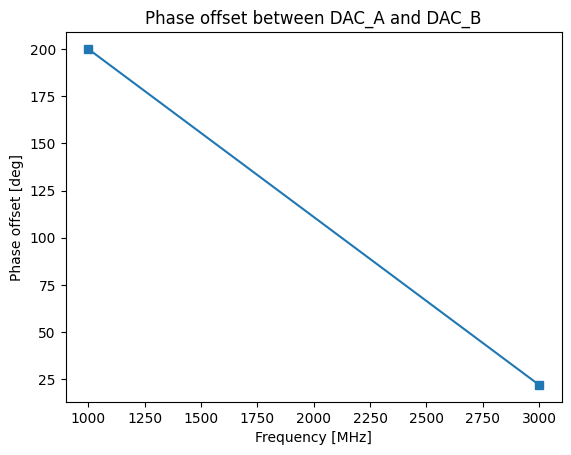

In [458]:
# FIXME: Don't like how this is relying on the order of the lists to work

DELAY = 0 # Change this to compensate for mismatched cable lengths etc.

# delta_phis = {}
delta_phi = {3000: 0}

for i in range(len(dac_freqs)):
    # phase_delay = 360 * dac_freqs[i] * DELAY
    delta_phis[dac_freqs[i]] = [((res[i][0][0] - res[i][1][0]) % 360), 0] 

x,y = [], []
for key, value in delta_phis.items():
    # print(f"{key}: {value[0]}")
    x.append(key)
    y.append(value[0])

plt.plot(x,y, marker="s")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [459]:
# Create program object
prog = QickProgram(soccfg)

# Method 1 - Run, specifying number of repetitions
pulse_sequences.generate_asm(prog, delta_phis, reps=10000000)

# Method 2 - Run with no repetitions
# raman_cooling.generate_asm(prog, gain=10000)

## Run program and print QICK assembly

In [460]:
# Load assembly to board
prog.config_all(soc)

# Run program
soc.tproc.start() 

# Useful for debugging synchronisation issues
# print(prog)